In [59]:
import matplotlib
#matplotlib.use('Agg')
%matplotlib tk
%autosave 180
import matplotlib.pyplot as plt
from IPython.core.display import display, HTML
display(HTML("<style>.container { width:100% !important; }</style>"))

import matplotlib.cm as cm
from matplotlib import gridspec
import parmap
import numpy as np
import pandas as pd
import os
import shutil
import cv2
import scipy.io as sio

import glob2

from numba import jit
from sklearn.svm import SVC # "Support vector classifier"

colors = [
'black','blue','red','green', 'cyan','orange','brown','slategrey','darkviolet','darkmagenta',
'firebrick','lawngreen','dodgerblue','crimson','orchid','slateblue',
'darkgreen','darkorange','indianred','darkviolet','deepskyblue','greenyellow',
'peru','cadetblue','forestgreen','slategrey','lightsteelblue','rebeccapurple',
'darkmagenta','yellow','hotpink']


Autosaving every 180 seconds


In [42]:
# functions
def plot_median_sem_over_single_trials(area_ids, trial_courses):
    ymin, ymax = -10, 10
    for k in range(area_ids.shape[0]):
        ax=plt.subplot(6,6,k+1)
        temp = trial_courses[:,k]
        median = np.nanmedian(temp, axis=0)
        print ("Area: ", area_ids[k])
        # compute STD and SEM
        std = np.nanstd(temp,axis=0)
        sem = std/float(trial_courses.shape[0])
        #print ("sem: ", sem.shape, " , mean: ", median.shape)
        plt.plot(median,c='blue')

        # plot individual trials
        #plt.plot(temp.T, c='black',alpha=.1)

    #     plt.fill_between(np.arange(mean.shape[0]), mean-std, mean+std,
    #                    alpha=0.2, facecolor='#089FFF',
    #                    linewidth=4, antialiased=True)

        plt.plot([0, trial_courses.shape[2]],[0,0], 'r--',c='black')
        plt.plot([trial_courses.shape[2]//2, trial_courses.shape[2]//2],
                [ymin, ymax], 'r--',c='black')

#         if area_ids[k]==100:
#             print ("Median: ", median, temp)
            # mean[mean == -np.inf] = 0
       # mean[mean == np.inf] = 0

        plt.ylim(-10, 10)
        #plt.fill_between(mean, mean-sem, mean+sem,color='grey')
        plt.plot(median+sem, color='red')
        plt.plot(median-sem, color='red')
        #idx = np.where(areanames[:,0]==area_ids[k])[0]
        #print (allen_ids[:10], area_ids[k])
        #idx = np.where(allen_ids-1==area_ids[k])[0]

        #print (allen_abbreviations[idx])
        #plt.title("Area: "+ allen_abbreviations[idx][0]+ ", "+str(area_ids[k]),
        #plt.title("Area: "+ allen_abbreviations[idx][0]+ ", "+str(area_ids[k]),
        plt.title("Area: "+ str(area_ids[k]),
                  fontsize=12, pad=.9)

        if k < (area_ids.shape[0]-1):
            plt.xticks([])

        if k == 0:
            plt.ylabel("DF/F %",fontsize=15)

    plt.suptitle("All significant areas (10pixels+): medians over # trials: "+
                 str(trial_courses.shape[0]), fontsize=16)

    plt.show()


def sum_pixels_in_registered_mask(data, maskwarp):

    print (" # of trials: ", data.shape[0])

    areas = np.unique(maskwarp) 
    print (" # of areas: ", areas.shape)
    
    # work in 1D vectors easier to mask
    maskwarp1D = maskwarp.reshape(-1)

    trial_courses = []
    area_ids = []
    for k in range(data.shape[0]):
        if k%10==0:
            print ("computing trial: ", k)
        time_courses_local = []

        # convert to 1D vector to mask faster
        data1D = np.float32(data[k].reshape(181,-1))
        for id_ in areas:
            idx = np.where(maskwarp1D==id_)[0]

            # only keep areas that have at least 10 pixels
            if idx.shape[0]>10:
                #print ("Area: ", id_)
                area_ids.append(id_)#print ("Areas: ", id_)
                #print (data1D[:,idx].shape)

                temp = data1D[:,idx]

                if False:
                    # compute DFF
                    F0 = np.nanmean(temp,axis=0)
                    dFF = (data1D[:,idx]-F0)/F0
                else:
                    # skip dFF computation;
                    dFF = temp
                
                # save average of all pixesl post DFF
                time_courses_local.append(np.nanmean(dFF, axis=1))

            #all_times.append(time_courses_local)
        trial_courses.append(time_courses_local)

    area_ids = np.int32(np.unique(area_ids))
    trial_courses = np.float32(trial_courses)
    print ("# trials, # areas, # times: ", trial_courses.shape)
    print ("area ids: ", area_ids.shape)

    return area_ids, trial_courses


def make_movie(data):
    
    from matplotlib import animation
    Writer = animation.writers['ffmpeg']
    writer = Writer(fps=5, metadata=dict(artist='Me'), bitrate=1800)

    fig = plt.figure()
    ax = fig.add_subplot(111)
    #ax.set_aspect('equal')
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)

    data = np.float32(data)
    print (data.shape)
    # data_trial = data[trial]

    # F0 = np.mean(data_trial[:30],axis=0)
    # print (F0.shape)

    # dFF = (data.mean(0) - F0)/F0
    # print ("dFF: ", dFF.shape)

    #dFF = data.mean(0)

    trial = 0
    print (np.nanmin(data), np.nanmax(data))
    n_frames = data.shape[0]
    print ("n_frames: ", n_frames)
    
    im = ax.imshow(data[data.shape[0]//2], vmin=-0.1, vmax=0.1, cmap='viridis')
    #im.set_clim([0,1])
    ax.set_title("")
    fig.set_size_inches([5,5])
   
    def update_img(n):
        #tmp = rand(300,300)
        
        print (n)
        ax.set_title(str(n))
        im.set_data(data[n])
        return im

    #legend(loc=0)
    ani = animation.FuncAnimation(fig, update_img,n_frames,interval=30)
    writer = animation.writers['ffmpeg'](fps=30)

    ani.save('/home/cat/video.mp4',writer=writer)
    plt.close()


def make_training_sets_multiple_tests(time, 
                                      trial_courses_fixed, trial_courses_fixed_ids,
                                      trial_courses_random_fixed, trial_courses_random_ids):
    
    # combine good trials with random trials for training sets:
    
    #time = 0
    good_trials = trial_courses_fixed[trial_courses_fixed_ids, :,time].reshape(trial_courses_fixed_ids.shape[0], -1)
    #print ("good trials: ", good_trials.shape)
    temp = np.arange(trial_courses_fixed.shape[0])
    idx = np.delete(temp,trial_courses_fixed_ids)
    test_trials = trial_courses_fixed[idx, :,time].reshape(idx.shape[0], -1)

    #print ("test_trials: ", test_trials.shape)
    
    random_trials = trial_courses_random_fixed[trial_courses_random_ids, :,time].reshape(trial_courses_random_ids.shape[0], -1)
    temp = np.arange(trial_courses_random.shape[0])
    idx = np.delete(temp,trial_courses_random_ids)
    test_trials_random = trial_courses_random_fixed[idx, :,time].reshape(idx.shape[0], -1)
    #print ("test_trials_random: ", test_trials_random.shape)

    # make labels
    y = np.zeros(good_trials.shape[0]+random_trials.shape[0],'int32')
    y[:good_trials.shape[0]]=1

    # concatenate
    X = np.vstack((good_trials,random_trials))

    print ("done time: ", time)
    return X, y, test_trials, test_trials_random



def make_training_sets(time, trial_courses_fixed, trial_courses_random_fixed):
    # combine good trials with random trials for training sets:
    
    #time = 0
    good_trials = trial_courses_fixed[:50, :,time].reshape(50, -1)
    #print ("good trials: ", good_trials.shape)
    test_trials = trial_courses_fixed[50:, :,time].reshape(13, -1)

    random_trials = trial_courses_random_fixed[:50, :,time].reshape(50, -1)
    #print ("random_trials: ", random_trials.shape)
    test_trials_random = trial_courses_random_fixed[50:, :,time].reshape(50, -1)

    # make labels
    y = np.zeros(100,'int32')
    y[:50]=1

    # concatenate
    X = np.vstack((good_trials,random_trials))

    print ("done time: ", time)
    return X, y, test_trials, test_trials_random

    
def make_training_sets_multi_times(times, trial_courses_fixed, trial_courses_random_fixed):
    # combine good trials with random trials for training sets:
    
    #time = 0
    good_trials = trial_courses_fixed[:50, :,times[0]:times[1]].reshape(50, -1)
    #print ("good trials: ", good_trials.shape)
    test_trials = trial_courses_fixed[50:, :,times[0]:times[1]].reshape(13, -1)

    random_trials = trial_courses_random_fixed[:50, :,times[0]:times[1]].reshape(50, -1)
    #print ("random_trials: ", random_trials.shape)
    test_trials_random = trial_courses_random_fixed[50:, :,times[0]:times[1]].reshape(50, -1)

    # make labels
    y = np.zeros(100,'int32')
    y[:50]=1

    # concatenate
    X = np.vstack((good_trials,random_trials))

    print ("done time: ", time)
    return X, y, test_trials, test_trials_random

def make_training_sets_multi_times_multi_areas(times, 
                                               area_id,
                                               trial_courses_fixed, 
                                               trial_courses_random_fixed):
    # combine good trials with random trials for training sets:
    
    #time = 0
    good_trials = trial_courses_fixed[:50, area_id,times[0]:times[1]].reshape(50, -1)
    #print ("good trials: ", good_trials.shape)
    test_trials = trial_courses_fixed[50:, area_id,times[0]:times[1]].reshape(13, -1)

    random_trials = trial_courses_random_fixed[:50, area_id,times[0]:times[1]].reshape(50, -1)
    #print ("random_trials: ", random_trials.shape)
    test_trials_random = trial_courses_random_fixed[50:, area_id,times[0]:times[1]].reshape(50, -1)

    # make labels
    y = np.zeros(100,'int32')
    y[:50]=1

    # concatenate
    X = np.vstack((good_trials,random_trials))

    #print ("done time: ", time)
    return X, y, test_trials, test_trials_random


def parallel_svm_multiple_tests(time, 
                                trial_courses_fixed, trial_courses_fixed_ids,
                                trial_courses_random_fixed, trial_courses_random_ids):

    res1 = []
    res2 = []
    for k in range(len(trial_courses_fixed_ids)):
        X, y, test_trials, test_trials_random = make_training_sets_multiple_tests(time, 
                                                                   trial_courses_fixed, trial_courses_fixed_ids[k],
                                                                   trial_courses_random_fixed, trial_courses_random_ids[k])

        #print (" X: ", X.shape, X[:5])
        print (" y: ", y.shape, y)
        
        model = SVC(kernel='linear', C=1)
        model.fit(X, y)

        #test_trials_rewarded = trial_courses_fixed[50:, :,time].reshape(50, -1)
        #model = grid.best_estimator_
        yfit = model.predict(test_trials)
        print ("predict test trial: ", yfit)
        res1.append(np.sum(yfit)/float(yfit.shape[0]))
        #real_data.append(res1)

        yfit = model.predict(test_trials_random)
        res2.append(np.sum(yfit)/float(yfit.shape[0]))
        #random_data.append(res2)
    
    return (res1, res2)

def parallel_svm_multi_time(times, trial_courses_fixed, trial_courses_random_fixed):
#for time in times:
    print ("times ", times)
    X, y, test_trials, test_trials_random = make_training_sets_multi_times(times, 
                                                                           trial_courses_fixed, 
                                                                           trial_courses_random_fixed)
    
    model = SVC(kernel='linear', C=2)
    model.fit(X, y)

    # test_trials_rewarded = trial_courses_fixed[50:, :,time].reshape(50, -1)
    # model = grid.best_estimator_
    yfit = model.predict(test_trials)
    res1 = np.sum(yfit)/float(yfit.shape[0])
    real_data.append(res1)
    
    yfit = model.predict(test_trials_random)
    res2 = np.sum(yfit)/float(yfit.shape[0])
    random_data.append(res2)
    
    print (res1, res2)
    return (res1, res2)

def parallel_svm_multi_time_multi_area(times, 
                                       areas,
                                       trial_courses_fixed, 
                                       trial_courses_random_fixed):
    print ("times ", times)
    
    res1_array = []
    res2_array = []
    
    for area_id in areas:
        X, y, test_trials, test_trials_random = make_training_sets_multi_times_multi_areas(
                                                                               times, 
                                                                               area_id,
                                                                               trial_courses_fixed, 
                                                                               trial_courses_random_fixed)

        model = SVC(kernel='linear', C=2)
        model.fit(X, y)

        # test_trials_rewarded = trial_courses_fixed[50:, :,time].reshape(50, -1)
        # model = grid.best_estimator_
        yfit = model.predict(test_trials)
        res1 = np.sum(yfit)/float(yfit.shape[0])
        res1_array.append(res1)

        yfit = model.predict(test_trials_random)
        res2 = np.sum(yfit)/float(yfit.shape[0])
        res2_array.append(res2)

    print ("done times: ", times)
    return (res1_array, res2_array)


def parallel_svm_multi_time_multi_area(times, 
                                                       areas,
                                                       trial_courses_fixed, 
                                                       trial_courses_random_fixed):
    print ("times ", times)
    
    res1_array = []
    res2_array = []
    
    for area_id in areas:
        X, y, test_trials, test_trials_random = make_training_sets_multi_times_multi_areas(
                                                                               times, 
                                                                               area_id,
                                                                               trial_courses_fixed, 
                                                                               trial_courses_random_fixed)

        model = SVC(kernel='linear', C=2)
        model.fit(X, y)

        # test_trials_rewarded = trial_courses_fixed[50:, :,time].reshape(50, -1)
        # model = grid.best_estimator_
        yfit = model.predict(test_trials)
        res1 = np.sum(yfit)/float(yfit.shape[0])
        res1_array.append(res1)

        yfit = model.predict(test_trials_random)
        res2 = np.sum(yfit)/float(yfit.shape[0])
        res2_array.append(res2)

    print ("done times: ", times)
    return (res1_array, res2_array)

In [16]:
# load the atlas labels
allen_ids = np.load('/home/cat/id.npy')
allen_abbreviations = np.loadtxt('/home/cat/abbreviations.txt', dtype='str')

# load Allen Institute afine transformation to scale data
maskwarp= np.load('/media/cat/1TB/data/yuki/iA2/tif_files/IA2am_May2_Week4_30Hz/maskwarp.npy')
print (maskwarp.shape)

# # load area nmaes from atlas
# allen = sio.loadmat('/home/cat/code/self_initiated_alex_locaNMF/locaNMF/data/AllenMap/'+'preprocessed_allenDorsalMap.mat')
# dorsalMapScaled = allen['dorsalMapScaled'].astype(float)
# print (dorsalMapScaled.shape)
# plt.imshow(dorsalMapScaled)
# plt.show()

# areanames =allen['areanames']
# print (areanames[:,0])

(128, 128)


In [7]:
# load single trials; shape = [# trials, # times, width, length]
data_singles = np.load('/media/cat/1TB/data/yuki/iA2/tif_files/IA2pm_Apr22_Week2_30Hz/data_all_trials_april22_singletrials.npy')
print (data_singles.shape)


(63, 181, 128, 128)


In [8]:
# accumulate mean activity in each ROI
# input data shape: [# trials, # times, width, height]
area_ids, trial_courses = sum_pixels_in_registered_mask(data_singles, maskwarp)

 # of trials:  63
 # of areas:  (253,)
computing trial:  0
computing trial:  10


/home/cat/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:96: RuntimeWarning: Mean of empty slice


computing trial:  20
computing trial:  30
computing trial:  40
computing trial:  50
computing trial:  60
# trials, # areas, # times:  (63, 35, 181)
area ids:  (35,)


In [9]:
# visualizations
if False:
    # plot averate in each area
    print ("time_courses: ", trial_courses.shape, ", areas: ", area_ids)
    plot_median_sem_over_single_trials(area_ids, trial_courses)

    # show movie
    print ("TODO: add mask on top of video (+ area #s)")
    make_movie(data_singles.mean(0))



In [10]:
# load random trials:
data_random = np.load('/media/cat/1TB/data/yuki/iA2/tif_files/IA2pm_Apr22_Week2_30Hz/IA2pm_Apr22_Week2_30Hz_3.0sec_butterworth_globalAverage_0.1hz_6.0hz_randomcode_stm.npy')
print (data_random.shape)

_, trial_courses_random = sum_pixels_in_registered_mask(data_random, maskwarp)
print (" randomized trial time courses: ", trial_courses_random.shape)
print (trial_courses_random.shape)

(100, 181, 128, 128)
 # of trials:  100
 # of areas:  (253,)
computing trial:  0
computing trial:  10
computing trial:  20
computing trial:  30
computing trial:  40
computing trial:  50
computing trial:  60
computing trial:  70
computing trial:  80
computing trial:  90
# trials, # areas, # times:  (100, 35, 181)
area ids:  (35,)
 randomized trial time courses:  (100, 35, 181)
(100, 35, 181)


In [13]:
trial_courses_fixed = trial_courses.reshape(trial_courses.shape[0],-1)
trial_courses_fixed = np.nan_to_num(trial_courses_fixed, nan=9999, posinf=9999, neginf=9999)
idx = np.where(trial_courses_fixed==9999)
print (idx)
trial_courses_fixed[idx]=0

print ('trial_courses_fixed: ', trial_courses_fixed.shape)
trial_courses_random_fixed = trial_courses_random.copy().reshape(trial_courses_random.shape[0],-1)
print ('trial_courses_random_fixed: ', trial_courses_random_fixed.shape)
trial_courses_random_fixed[:,idx[1]] = 0

ax=plt.subplot(121)
plt.title("Event triggered")
plt.imshow(trial_courses_fixed, aspect='auto', vmin=-.15, vmax=.15)
trial_courses_fixed = trial_courses_fixed.reshape(trial_courses.shape)
print ("trial_courses_fixed: ", trial_courses_fixed.shape)

ax=plt.subplot(122)
plt.title("Random triggered")
plt.imshow(trial_courses_random_fixed, aspect='auto', vmin=-.15, vmax=.15)
trial_courses_random_fixed = trial_courses_random_fixed.reshape(trial_courses_random.shape)

plt.show()

(array([ 0,  0,  0, ..., 62, 62, 62]), array([2534, 2535, 2536, ..., 5789, 5790, 5791]))
trial_courses_fixed:  (63, 6335)
trial_courses_random_fixed:  (100, 6335)
trial_courses_fixed:  (63, 35, 181)


In [46]:
# SVM Classification on single times
print (" trial_courses_fixed; ", trial_courses_fixed.shape)
print (" randomized trial time courses: ", trial_courses_random.shape)

# make 10 batches of data to train and test over    
temp = np.arange(50)
trial_courses_fixed_ids = []
trial_courses_random_fixed_ids = []
for k in range(10):
    trial_courses_fixed_ids.append(temp+k)
    trial_courses_random_fixed_ids.append(temp+k)

# start 
times = np.arange(0,181)
if True:
    res = parmap.map(parallel_svm_multiple_tests, 
                     times, 
                     trial_courses_fixed, trial_courses_fixed_ids,
                     trial_courses_random_fixed, trial_courses_random_fixed_ids,
                     pm_processes=4)
else:
    res = parallel_svm_multiple_tests(times[0], 
                                     trial_courses_fixed, 
                                     trial_courses_fixed_ids,
                                     trial_courses_random_fixed, 
                                     trial_courses_random_fixed_ids)
    
    
res = np.vstack(res)
print (res)
print ("DONE")

 trial_courses_fixed;  (63, 35, 181)
 randomized trial time courses:  (100, 35, 181)
done time:  0
 y:  (100,) [1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 1 1 1 1 1 1 1 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
done time:  12
predict test trial:  [1 0 1 0 0 1 1 1 0 1 1 1 1]
 y:  (100,) [1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 1 1 1 1 1 1 1 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
predict test trial:  [1 0 1 0 0 0 0 1 0 1 0 1 1]
done time:  24
 y:  (100,) [1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 1 1 1 1 1 1 1 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]done time:  0

done time:  36
 y:  (100,) [1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 

 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]predict test trial:  [1 1 0 1 1 1 0 1 0 1 1 1 1]
predict test trial:  [1 0 1 0 0 1 1 1 0 1 1 1 1]

done time:  24
done time:  1
 y:  (100,) [1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 1 1 1 1 1 1 1 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]predict test trial:  [0 0 1 1 0 1 0 1 1 0 1 1 1]
 y:  (100,) [1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 1 1 1 1 1 1 1 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
done time:  37

 y:  (100,) [1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 1 1 1 1 1 1 1 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]

predict test trial:  [0 0 1 0 0 1 1 1 0 1 1 1 1]
predict test trial:  [0 1 1 1 1 1 1 0 1 0 1 1 1]
predict 

 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]predict test trial:  [1 1 0 1 1 0 0 1 0 1 1 1 1]
predict test trial:  [0 1 1 0 0 0 0 1 0 1 0 1 1]

done time:  24
done time:  37
done time:  13
 y:  (100,) [1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 1 1 1 1 1 1 1 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]predict test trial:  [0 0 1 0 0 1 1 1 0 1 1 1 1]

 y:  (100,) [1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 1 1 1 1 1 1 1 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]predict test trial:  [1 1 0 1 1 0 0 1 0 1 1 1 1]

 y:  (100,) [1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 1 1 1 1 1 1 1 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]done time:  24

done time:  2
predict test trial:  [0 1 1 

 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
predict test trial:  [0 1 0 1 1 1 0 1 0 1 1 1 1]
predict test trial:  [0 0 1 1 0 0 1 0 1 0 1 0 0]
done time:  25
predict test trial:  [1 0 1 0 0 1 1 1 0 1 1 1 1]
done time:  38
done time:  3
 y:  (100,) [1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 1 1 1 1 1 1 1 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0] y:  (100,) [1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 1 1 1 1 1 1 1 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]

predict test trial:  [0 1 0 1 1 1 0 1 0 1 1 1 1]
predict test trial:  [0 0 1 0 0 1 1 1 0 0 1 1 1]
 y:  (100,) [1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 1 1 1 1 1 1 1 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
done time

 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]done time:  39


predict test trial:  [0 1 1 1 1 0 0 1 0 1 1 1 1]
predict test trial:  [0 1 0 0 0 1 0 1 0 1 0 1 1]
 y:  (100,) [1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 1 1 1 1 1 1 1 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]done time:  26
done time:  14


 y:  (100,) [1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 1 1 1 1 1 1 1 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]predict test trial:  [0 1 1 0 0 1 0 1 1 1 1 1 1]
predict test trial:  [1 1 1 1 1 0 1 0 1 0 1 1 1]
done time:  4
done time:  39
 y:  (100,) [1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 1 1 1 1 1 1 1 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0] y:  (100,) [1 1 1 1 1 1 1 1


done time:  4
 y:  (100,) [1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 1 1 1 1 1 1 1 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]predict test trial:  [0 0 0 0 0 1 0 1 0 1 0 1 1]


done time:  27
predict test trial:  [0 1 1 0 0 1 1 1 0 0 1 1 1]
predict test trial:  [0 0 0 0 0 0 0 0 1 0 1 0 0]
 y:  (100,) [1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 1 1 1 1 1 1 1 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]done time:  4
done time:  39

 y:  (100,) [1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 1 1 1 1 1 1 1 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0] y:  (100,) [1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 1 1 1 1 1 1 1 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 

 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]done time:  15

 y:  (100,) [1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 1 1 1 1 1 1 1 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0] y:  (100,) [1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 1 1 1 1 1 1 1 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
predict test trial:  [0 1 0 0 1 0 0 1 0 1 0 1 1]
predict test trial:  [1 1 1 1 1 0 0 1 1 1 1 1 1]

done time:  27

done time:  16
predict test trial:  [0 0 0 0 0 0 0 0 0 0 0 0 0]
 y:  (100,) [1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 1 1 1 1 1 1 1 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]predict test trial:  [0 1 1 0 0 0 1 1 0 1 1 1 1]
done time:  40

done time:  5
 y:  (100,) [1 1 1 1 1 1 1 

 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0] y:  (100,) [1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 1 1 1 1 1 1 1 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]predict test trial:  [0 0 1 0 0 1 1 1 0 0 1 1 1]


done time:  6
predict test trial:  [0 1 1 0 1 0 0 1 0 1 1 1 1]
predict test trial:  [0 0 0 1 0 0 0 0 0 0 0 0 0]
 y:  (100,) [1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 1 1 1 1 1 1 1 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]predict test trial:  [0 1 0 0 1 1 0 1 0 1 0 1 1]

done time:  41
done time:  16
 y:  (100,) [1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 1 1 1 1 1 1 1 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]done time:  28

 y:  (100,) [1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 

 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]

predict test trial:  [0 1 1 0 0 1 0 1 0 1 1 1 1]
predict test trial:  [0 0 1 1 0 0 0 0 0 0 0 0 0]
predict test trial:  [0 1 0 0 0 0 0 1 0 1 0 1 1]
done time:  6
done time:  42
 y:  (100,) [1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 1 1 1 1 1 1 1 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0] y:  (100,) [1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 1 1 1 1 1 1 1 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]

predict test trial:  [0 1 0 0 0 1 0 1 0 1 0 1 1]
predict test trial:  [0 1 1 0 0 1 0 1 0 1 1 1 1]
predict test trial:  [0 0 0 0 0 0 0 0 0 0 0 0 0]
done time:  17
done time:  29
done time:  42
 y:  (100,) [1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 1 1 1 1 1 1 1 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0

 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]done time:  43
predict test trial:  [1 1 0 0 0 0 0 1 0 1 0 1 1]

predict test trial:  [0 1 1 0 0 0 1 1 0 1 1 1 1]
done time:  18
 y:  (100,) [1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 1 1 1 1 1 1 1 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
 y:  (100,) [1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 1 1 1 1 1 1 1 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]done time:  7

 y:  (100,) [1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 1 1 1 1 1 1 1 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
predict test trial:  [0 0 0 0 0 0 0 0 0 0 0 0 0]
predict test trial:  [0 1 0 0 1 0 0 1 0 1 1 0 1]
predict test trial:  [0 1 0 0 0 0 0 1 0 1 0 1 1]
done time

predict test trial:  [1 1 0 0 0 1 0 1 0 1 0 1 1]
 y:  (100,) [1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 1 1 1 1 1 1 1 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]done time:  18
predict test trial:  [0 0 1 0 0 0 0 1 0 0 1 1 1]
 y:  (100,) [1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 1 1 1 1 1 1 1 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]done time:  30


done time:  8
 y:  (100,) [1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 1 1 1 1 1 1 1 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0] y:  (100,) [1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 1 1 1 1 1 1 1 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 

 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]predict test trial:  [0 1 1 0 0 0 0 1 0 0 1 1 1]
predict test trial:  [1 0 0 0 0 1 0 1 0 1 0 1 1]
done time:  19
 y:  (100,) [1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 1 1 1 1 1 1 1 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]done time:  8

 y:  (100,) [1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 1 1 1 1 1 1 1 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]done time:  31
predict test trial:  [0 1 0 0 1 0 0 0 0 1 0 1 0]
 y:  (100,) [1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 1 1 1 1 1 1 1 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]

done time:  19
predict test trial:  [1 1 0 0 0 1 0 1 0 1 0 1 1]
 y:  (100,) [1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1

 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]done time:  45

 y:  (100,) [1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 1 1 1 1 1 1 1 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
predict test trial:  [0 1 0 0 0 0 0 0 0 1 0 1 0]
predict test trial:  [0 1 0 0 0 0 0 1 0 1 0 1 1]
 y:  (100,) [1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 1 1 1 1 1 1 1 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
predict test trial:  [0 1 1 0 0 0 0 1 0 0 1 1 1]
done time:  32
predict test trial:  [0 0 0 0 0 0 0 0 0 0 0 0 0]
done time:  9
 y:  (100,) [1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 1 1 1 1 1 1 1 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0] y:  (100,) [1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 

 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0] y:  (100,) [1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 1 1 1 1 1 1 1 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]

predict test trial:  [0 0 1 0 0 0 0 1 0 0 1 1 1]
predict test trial:  [0 0 0 0 0 0 0 0 0 0 0 0 0]
 y:  (100,) [1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 1 1 1 1 1 1 1 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]done time:  10

 y:  (100,) [1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 1 1 1 1 1 1 1 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]done time:  46

predict test trial:  [0 0 0 0 0 0 0 0 0 0 0 0 1]
done time:  33
predict test trial:  [0 1 1 0 0 0 0 1 0 0 1 1 1]
 y:  (100,) [1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 

 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
predict test trial:  [0 1 0 0 1 0 0 1 0 1 0 1 1]
predict test trial:  [0 0 0 0 0 0 0 0 0 0 0 0 1]
done time:  21
predict test trial:  [0 1 0 1 0 0 0 0 0 1 0 1 0]
 y:  (100,) [1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 1 1 1 1 1 1 1 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0] y:  (100,) [1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 1 1 1 1 1 1 1 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]done time:  47

done time:  33

predict test trial:  [1 0 1 0 0 0 0 1 0 0 0 1 1]
 y:  (100,) [1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 1 1 1 1 1 1 1 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]predict test trial:  [0 1 0 0 1 0 0 1 0 1 0 1 1]
done time

 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0] y:  (100,) [1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 1 1 1 1 1 1 1 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0] y:  (100,) [1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 1 1 1 1 1 1 1 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]


predict test trial:  [0 0 0 0 0 0 0 0 0 0 0 0 1]
 y:  (100,) [1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 1 1 1 1 1 1 1 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]predict test trial:  [0 1 1 0 0 0 0 1 0 1 1 1 1]
done time:  11

 y:  (100,) [1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 1 1 1 1 1 1 1 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 

 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]

predict test trial:  [0 0 0 0 0 0 0 0 0 0 0 1 1]
predict test trial:  [0 0 1 1 0 0 1 0 1 0 1 1 1]
done time:  60
done time:  48
 y:  (100,) [1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 1 1 1 1 1 1 1 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]done time:  35
 y:  (100,) [1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 1 1 1 1 1 1 1 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0] y:  (100,) [1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 1 1 1 1 1 1 1 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]

predict test trial:  [0 1 1 0 1 0 1 0 0 0 0 1 1]
done time:  60
predict test trial:  [0 0 0 0 0 0 0 0 0 0 0 1 1]
 y:  (100,) [1 1 1 1 1 1 1 1 1 1 1 1 1 1 1

 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
 y:  (100,) [1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 1 1 1 1 1 1 1 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0] y:  (100,) [1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 1 1 1 1 1 1 1 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]

predict test trial:  [0 0 1 1 0 1 1 1 1 0 1 1 1]
predict test trial:  [0 0 0 0 0 0 0 0 0 0 0 1 1]
predict test trial:  [0 1 0 1 1 1 0 1 0 1 1 1 1]
done time:  61
done time:  49
 y:  (100,) [1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 1 1 1 1 1 1 1 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0] y:  (100,) [1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 1 1 1 1 1 1 1 1 0 0 0 0 

 y:  (100,) [1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 1 1 1 1 1 1 1 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
done time:  61
done time:  72
 y:  (100,) [1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 1 1 1 1 1 1 1 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]predict test trial:  [0 0 0 0 0 0 0 0 0 0 0 1 1]
done time:  84
 y:  (100,) [1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 1 1 1 1 1 1 1 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]

predict test trial:  [0 1 1 0 0 0 1 1 1 0 1 1 1]
done time:  62
predict test trial:  [1 1 1 1 1 1 1 1 1 0 1 1 1]
 y:  (100,) [1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 1 1 1 1 1 1 1 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0

 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]predict test trial:  [0 1 1 0 0 0 1 0 0 0 1 1 1]

predict test trial:  [0 0 0 1 0 0 0 0 0 0 0 1 1]
done time:  62
 y:  (100,) [1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 1 1 1 1 1 1 1 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]done time:  51
predict test trial:  [0 1 1 0 1 1 0 1 0 0 1 1 1]

 y:  (100,) [1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 1 1 1 1 1 1 1 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]done time:  84
 y:  (100,) [1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 1 1 1 1 1 1 1 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
predict test trial:  [0 1 1 0 0 0 1 0 0 0 1 1 1]
predict test trial:  [0 0 0 0 1 0 0 0 0 0 0 1 1]
done time

 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
predict test trial:  [0 1 1 0 0 1 0 1 0 0 1 1 1]
 y:  (100,) [1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 1 1 1 1 1 1 1 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0] y:  (100,) [1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 1 1 1 1 1 1 1 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]done time:  85


 y:  (100,) [1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 1 1 1 1 1 1 1 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
done time:  52
 y:  (100,) [1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 1 1 1 1 1 1 1 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]pred

 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0] y:  (100,) [1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 1 1 1 1 1 1 1 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]


predict test trial:  [0 1 1 0 0 1 0 1 0 1 1 1 1]

predict test trial:  [0 0 1 0 0 0 1 0 0 0 1 1 1]
done time:  86
done time:  64
 y:  (100,) [1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 1 1 1 1 1 1 1 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]predict test trial:  [0 0 0 0 0 0 0 1 0 0 0 1 1]
 y:  (100,) [1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 1 1 1 1 1 1 1 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]

predict test trial:  [0 1 1 0 0 0 1 0 0 0 1 1 1]
predict test trial:  [0 1 1 0 0 1 0 1 0 1 1 1 1]
done time:  53
done t

done time:  64
 y:  (100,) [1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 1 1 1 1 1 1 1 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]predict test trial:  [0 1 1 0 1 1 0 1 0 1 1 1 1]


done time:  53
predict test trial:  [0 1 1 0 1 1 0 1 0 0 1 1 1]
 y:  (100,) [1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 1 1 1 1 1 1 1 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]done time:  75
 y:  (100,) [1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 1 1 1 1 1 1 1 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]done time:  87

 y:  (100,) [1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 1 1 1 1 1 1 1 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0

 y:  (100,) [1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 1 1 1 1 1 1 1 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]done time:  87

predict test trial:  [0 1 1 1 1 0 1 1 0 0 1 1 1]
 y:  (100,) [1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 1 1 1 1 1 1 1 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]done time:  75

predict test trial:  [0 1 1 1 1 0 1 0 0 0 1 1 1]
 y:  (100,) [1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 1 1 1 1 1 1 1 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
done time:  65
predict test trial:  [1 1 1 0 1 1 1 0 0 1 1 1 1]
 y:  (100,) [1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 1 1 1 1 1 1 1 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 

 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
predict test trial:  [1 1 1 1 1 1 0 1 0 1 1 1 1]

predict test trial:  [0 1 1 0 1 1 0 1 0 0 1 1 1]
done time:  88
done time:  76
 y:  (100,) [1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 1 1 1 1 1 1 1 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0] y:  (100,) [1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 1 1 1 1 1 1 1 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]

predict test trial:  [0 1 1 0 1 0 1 0 0 0 1 1 1]
predict test trial:  [0 0 1 0 0 0 0 0 0 0 0 1 1]
predict test trial:  [1 1 1 1 1 1 0 1 0 1 1 1 1]
done time:  66
done time:  88
predict test trial:  [0 1 1 0 1 0 0 1 0 0 1 1 1]
done time:  54
 y:  (100,) [1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 1 1 1 1 1 1 1 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 

 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0] y:  (100,) [1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 1 1 1 1 1 1 1 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0] y:  (100,) [1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 1 1 1 1 1 1 1 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]



predict test trial:  [1 1 1 0 1 1 0 1 0 1 1 1 1]
predict test trial:  [0 1 1 0 1 1 0 1 1 0 1 1 1]
predict test trial:  [0 0 1 0 1 0 0 0 0 0 0 1 1]
predict test trial:  [0 1 1 0 0 0 1 1 0 0 1 1 1]
done time:  77
done time:  89
 y:  (100,) [1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 1 1 1 1 1 1 1 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0] y:  (100,) [1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1

IOPub message rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_msg_rate_limit`.

Current values:
NotebookApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
NotebookApp.rate_limit_window=3.0 (secs)





done time:  106
 y:  (100,) [1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 1 1 1 1 1 1 1 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0] y:  (100,) [1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 1 1 1 1 1 1 1 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
predict test trial:  [0 0 1 1 1 0 1 1 1 1 1 1 1]
predict test trial:  [0 1 1 0 0 1 0 1 1 0 1 1 1]
predict test trial:  [0 0 1 1 0 1 1 1 1 1 1 1 1]
done time:  128
done time:  140
 y:  (100,) [1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 1 1 1 1 1 1 1 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0] y:  (100,) [1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 1 1 1 1 1 1 1 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0

 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
predict test trial:  [0 0 1 1 0 1 1 1 1 1 1 0 1]
predict test trial:  [0 1 1 0 1 0 0 1 1 0 1 1 1]
done time:  140
done time:  107
 y:  (100,) [1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 1 1 1 1 1 1 1 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]predict test trial:  [0 0 1 1 1 1 1 1 1 1 1 1 1]

 y:  (100,) [1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 1 1 1 1 1 1 1 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]done time:  129

done time:  117
 y:  (100,) [1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 1 1 1 1 1 1 1 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
 y:  (100,) [1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1


 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
predict test trial:  [0 0 1 1 1 0 1 1 1 1 1 0 1]

done time:  144
done time:  130
predict test trial:  [0 0 1 1 0 0 1 1 1 1 1 0 1]
 y:  (100,) [1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 1 1 1 1 1 1 1 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
done time:  141
predict test trial:  [0 1 1 1 1 1 0 0 1 1 1 1 1]
 y:  (100,) [1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 1 1 1 1 1 1 1 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]done time:  118
 y:  (100,) [1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 1 1 1 1 1 1 1 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]

 y:  (100,) [1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1

 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0] y:  (100,) [1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 1 1 1 1 1 1 1 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
 y:  (100,) [1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 1 1 1 1 1 1 1 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
done time:  144

predict test trial:  [0 0 1 1 1 0 1 1 1 1 1 1 1]
predict test trial:  [0 0 1 1 1 1 1 1 0 1 1 1 1]
done time:  142
predict test trial:  [0 1 1 0 0 1 1 1 1 0 1 1 1]
 y:  (100,) [1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 1 1 1 1 1 1 1 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
done time:  119
done time:  130
 y:  (100,) [1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1


done time:  143
done time:  131
done time:  145
done time:  119
 y:  (100,) [1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 1 1 1 1 1 1 1 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0] y:  (100,) [1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 1 1 1 1 1 1 1 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0] y:  (100,) [1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 1 1 1 1 1 1 1 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0] y:  (100,) [1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 1 1 1 1 1 1 1 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]



predict test trial:  [0 1 1 1 1 0 1 1 1 1 1 1 1]
predict test trial:  [1

 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]predict test trial:  [0 0 1 1 1 1 0 0 1 0 0 1 1]


done time:  143
done time:  168
 y:  (100,) [1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 1 1 1 1 1 1 1 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]predict test trial:  [1 0 1 1 1 1 0 1 1 1 0 0 1]
 y:  (100,) [1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 1 1 1 1 1 1 1 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
done time:  156

 y:  (100,) [1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 1 1 1 1 1 1 1 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]predict test trial:  [0 0 1 0 1 1 0 0 1 0 0 1 0]

predict test trial:  [0 0 1 1 1 0 1 1 1 1 1 0 1]
predict test trial:  [1 1 1 1 0 1 1 1 1 1 1 0 1]
done

 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]

predict test trial:  [0 0 1 1 1 1 0 0 1 0 0 1 0]
predict test trial:  [1 0 1 1 1 1 0 1 1 1 0 0 1]
predict test trial:  [1 1 1 1 1 1 1 0 1 0 1 1 1]
 y:  (100,) [1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 1 1 1 1 1 1 1 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]done time:  169

done time:  157
 y:  (100,) [1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 1 1 1 1 1 1 1 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0] y:  (100,) [1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 1 1 1 1 1 1 1 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]

predict test trial:  [0 0 1 1 0 1 1 1 1 1 1 0 1]
done time:  180
done time:  146
 y:  (100,) [1 1 1 1 1 1 1 1 1 1 1 1 

 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
done time:  170
predict test trial:  [0 0 1 1 0 1 1 1 1 1 1 0 1]
predict test trial:  [1 0 1 1 1 1 0 1 1 1 1 0 1]
 y:  (100,) [1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 1 1 1 1 1 1 1 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]done time:  147
done time:  158

 y:  (100,) [1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 1 1 1 1 1 1 1 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0] y:  (100,) [1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 1 1 1 1 1 1 1 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]

predict test trial:  [1 1 1 1 1 1 0 0 1 0 0 1 0]
predict test trial:  [0 0 1 1 0 1 1 1 1 1 1 0 1]
predict test trial:  [0 0 1 1 1 1 0 1 1 1 0 0 1]
done 

 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
 y:  (100,) [1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 1 1 1 1 1 1 1 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]done time:  158

 y:  (100,) [1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 1 1 1 1 1 1 1 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
predict test trial:  [0 0 1 1 0 1 1 1 0 1 1 0 1]
predict test trial:  [1 1 1 1 1 1 0 0 1 0 0 1 0]
done time:  148
predict test trial:  [1 0 1 1 0 1 1 1 0 1 1 1 1]
 y:  (100,) [1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 1 1 1 1 1 1 1 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]done time:  171

done time:  159
 y:  (100,) [1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1


 y:  (100,) [1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 1 1 1 1 1 1 1 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]done time:  149

predict test trial:  [0 0 1 1 0 1 1 1 0 1 1 1 1]
 y:  (100,) [1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 1 1 1 1 1 1 1 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
done time:  160
predict test trial:  [0 0 1 0 0 1 1 1 1 0 0 1 0]
 y:  (100,) [1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 1 1 1 1 1 1 1 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
predict test trial:  [0 0 1 1 0 1 1 1 0 1 0 0 1]
done time:  172
predict test trial:  [1 0 1 1 1 1 1 0 1 1 1 0 1]
 y:  (100,) [1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 1 1 1 1 1 

 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]done time:  172
predict test trial:  [0 0 1 1 0 1 0 1 0 1 0 0 1]
 y:  (100,) [1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 1 1 1 1 1 1 1 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]done time:  150
 y:  (100,) [1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 1 1 1 1 1 1 1 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]

predict test trial:  [0 0 1 0 0 1 1 1 1 0 0 1 1]
predict test trial:  [0 0 1 1 0 1 1 1 0 1 0 0 1]

done time:  173
done time:  150
 y:  (100,) [1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 1 1 1 1 1 1 1 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0] y:  (100,) [1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 

 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]done time:  173
 y:  (100,) [1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 1 1 1 1 1 1 1 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]

 y:  (100,) [1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 1 1 1 1 1 1 1 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
predict test trial:  [1 0 1 1 0 1 1 1 1 1 0 0 1]
predict test trial:  [1 0 1 1 1 1 1 0 1 1 1 0 1]
predict test trial:  [0 0 1 0 0 1 1 0 1 0 0 1 0]
done time:  151
done time:  162
 y:  (100,) [1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 1 1 1 1 1 1 1 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]done time:  173
 y:  (100,) [1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 

done time:  163
predict test trial:  [1 0 1 1 0 1 1 1 1 1 0 0 1]
 y:  (100,) [1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 1 1 1 1 1 1 1 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0] y:  (100,) [1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 1 1 1 1 1 1 1 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
done time:  152

 y:  (100,) [1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 1 1 1 1 1 1 1 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
predict test trial:  [0 0 1 1 0 1 0 0 1 0 0 1 1]
predict test trial:  [0 0 1 1 1 1 0 0 1 1 0 0 1]
done time:  174
predict test trial:  [1 0 1 1 0 1 1 1 1 1 0 0 1]
done time:  163
 y:  (100,) [1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 

 y:  (100,) [1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 1 1 1 1 1 1 1 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]done time:  175
done time:  153
 y:  (100,) [1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 1 1 1 1 1 1 1 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
 y:  (100,) [1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 1 1 1 1 1 1 1 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]predict test trial:  [1 0 1 1 0 1 0 0 1 0 1 1 1]


done time:  175
predict test trial:  [1 0 1 1 0 1 1 1 1 1 0 0 1]
 y:  (100,) [1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 1 1 1 1 1 1 1 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0

 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
done time:  176
 y:  (100,) [1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 1 1 1 1 1 1 1 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]predict test trial:  [1 0 1 1 0 1 0 1 1 1 0 0 1]
predict test trial:  [0 0 1 1 0 1 1 1 0 1 0 1 1]

done time:  154
done time:  165
predict test trial:  [1 0 1 1 0 1 0 0 1 0 1 1 1]
 y:  (100,) [1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 1 1 1 1 1 1 1 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0] y:  (100,) [1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 1 1 1 1 1 1 1 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]

done time:  176
 y:  (100,) [1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1



predict test trial:  [1 0 1 1 1 1 0 1 1 1 0 1 1]
done time:  155
 y:  (100,) [1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 1 1 1 1 1 1 1 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
predict test trial:  [1 0 1 1 0 1 0 1 1 1 0 1 1]
done time:  155
 y:  (100,) [1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 1 1 1 1 1 1 1 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]predict test trial:  [1 1 1 1 0 1 1 0 1 0 1 1 1]

done time:  177
done time:  165
 y:  (100,) [1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 1 1 1 1 1 1 1 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]predict test trial:  [1 0 1 1 0 1 0 1 1 1 0 0 1]

done time:  155
 y:  (100,) [1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 

done time:  167
 y:  (100,) [1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 1 1 1 1 1 1 1 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]

predict test trial:  [0 0 1 1 1 1 0 0 1 0 0 1 0]
done time:  167
predict test trial:  [1 1 1 1 1 1 1 1 1 0 1 1 1]
 y:  (100,) [1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 1 1 1 1 1 1 1 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
done time:  178
 y:  (100,) [1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 1 1 1 1 1 1 1 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
predict test trial:  [0 0 1 1 1 1 0 0 1 0 0 1 1]
done time:  167
predict test trial:  [1 1 1 1 1 1 1 1 1 0 1 1 1]
 y:  (100,) [1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1

In [56]:
print (res.shape)
real_res = res[::2]
print (real_res.shape)
random_res = res[1::2]
print (random_res.shape)


# PLOTS FOR SINGLE AREA / CUMULATIVE AREAS
t = np.arange(real_res.shape[0])/30-3
#plt.plot(t,res[:,0],c='blue')
print (t.shape, t)
y = real_res.mean(1)
print (y.shape, y)
e = real_res.std(1)
print (e.shape, e)
plt.errorbar(t, y, e, linestyle='None', marker='^', c='blue')
plt.plot(t, y,c='blue')

#plt.plot(t,res[:,1],c='red')
y = random_res.mean(1)
e = random_res.std(1)
plt.errorbar(t, y, e, linestyle='None', marker='^', c='red')
plt.plot(t,y,c='red')
# labels
plt.title("Decoding rewarded trials (blue); random trials (red)"+
         "\nUsing single frame of data (@30Hz) bins",fontsize=20)
plt.plot([-3,3],[0.5,0.5],'r--',c='black')
plt.plot([0,0],[0,1],'r--',c='black')
plt.xlabel("Time (sec)",fontsize=20)
plt.ylabel("Probability (dash=chance)",fontsize=20)

plt.show()

(362, 10)
(181, 10)
(181, 10)
(181,) [-3.         -2.96666667 -2.93333333 -2.9        -2.86666667 -2.83333333
 -2.8        -2.76666667 -2.73333333 -2.7        -2.66666667 -2.63333333
 -2.6        -2.56666667 -2.53333333 -2.5        -2.46666667 -2.43333333
 -2.4        -2.36666667 -2.33333333 -2.3        -2.26666667 -2.23333333
 -2.2        -2.16666667 -2.13333333 -2.1        -2.06666667 -2.03333333
 -2.         -1.96666667 -1.93333333 -1.9        -1.86666667 -1.83333333
 -1.8        -1.76666667 -1.73333333 -1.7        -1.66666667 -1.63333333
 -1.6        -1.56666667 -1.53333333 -1.5        -1.46666667 -1.43333333
 -1.4        -1.36666667 -1.33333333 -1.3        -1.26666667 -1.23333333
 -1.2        -1.16666667 -1.13333333 -1.1        -1.06666667 -1.03333333
 -1.         -0.96666667 -0.93333333 -0.9        -0.86666667 -0.83333333
 -0.8        -0.76666667 -0.73333333 -0.7        -0.66666667 -0.63333333
 -0.6        -0.56666667 -0.53333333 -0.5        -0.46666667 -0.43333333
 -0.4        -

In [47]:
# SVM - all areas at once; + time window
times1 = np.arange(0,151,1)
times2 = np.arange(30,181,1)
times = np.vstack((times1,times2)).T
#print (times)
res = parmap.map(parallel_svm_multi_time, times, trial_courses_fixed, 
                 trial_courses_random_fixed,
                 pm_processes=4)

#print (times)
# parallel_svm_multi_time(times[0], trial_courses_fixed, 
#                         trial_courses_random_fixed)

res = np.vstack(res)

[[  0  30]
 [  1  31]
 [  2  32]
 [  3  33]
 [  4  34]
 [  5  35]
 [  6  36]
 [  7  37]
 [  8  38]
 [  9  39]
 [ 10  40]
 [ 11  41]
 [ 12  42]
 [ 13  43]
 [ 14  44]
 [ 15  45]
 [ 16  46]
 [ 17  47]
 [ 18  48]
 [ 19  49]
 [ 20  50]
 [ 21  51]
 [ 22  52]
 [ 23  53]
 [ 24  54]
 [ 25  55]
 [ 26  56]
 [ 27  57]
 [ 28  58]
 [ 29  59]
 [ 30  60]
 [ 31  61]
 [ 32  62]
 [ 33  63]
 [ 34  64]
 [ 35  65]
 [ 36  66]
 [ 37  67]
 [ 38  68]
 [ 39  69]
 [ 40  70]
 [ 41  71]
 [ 42  72]
 [ 43  73]
 [ 44  74]
 [ 45  75]
 [ 46  76]
 [ 47  77]
 [ 48  78]
 [ 49  79]
 [ 50  80]
 [ 51  81]
 [ 52  82]
 [ 53  83]
 [ 54  84]
 [ 55  85]
 [ 56  86]
 [ 57  87]
 [ 58  88]
 [ 59  89]
 [ 60  90]
 [ 61  91]
 [ 62  92]
 [ 63  93]
 [ 64  94]
 [ 65  95]
 [ 66  96]
 [ 67  97]
 [ 68  98]
 [ 69  99]
 [ 70 100]
 [ 71 101]
 [ 72 102]
 [ 73 103]
 [ 74 104]
 [ 75 105]
 [ 76 106]
 [ 77 107]
 [ 78 108]
 [ 79 109]
 [ 80 110]
 [ 81 111]
 [ 82 112]
 [ 83 113]
 [ 84 114]
 [ 85 115]
 [ 86 116]
 [ 87 117]
 [ 88 118]
 [ 89 119]
 [ 90 120]

0.5384615384615384 0.54
times  [122 152]
done time:  180
0.46153846153846156 0.54
0.5384615384615384 0.42
times  [118 148]
done time:  180
times  [130 160]
done time:  180
0.5384615384615384 0.54
times  [109 139]
done time:  180
0.5384615384615384 0.56
times  [123 153]
done time:  180
0.46153846153846156 0.54
times  [119 149]
0.6923076923076923 0.56
times  [131 161]
done time:  180
done time:  180
0.5384615384615384 0.52
0.5384615384615384 0.54
times  [140 170]
done time:  180
0.5384615384615384 0.56
times  [132 162]
done time:  180
times  [124 154]
0.46153846153846156 0.54
done time:  180
times  [150 180]
done time:  180
0.46153846153846156 0.5
times  [141 171]
done time:  180
0.46153846153846156 0.58
times  [133 163]
done time:  180
0.6153846153846154 0.52
times  [125 155]
0.6923076923076923 0.58
done time:  180
0.46153846153846156 0.5
times  [142 172]
done time:  180
0.46153846153846156 0.54
times  [134 164]
done time:  180
0.6153846153846154 0.52
times  [126 156]
done time:  180
0.

In [22]:
# SVM time window; area specific

times1 = np.arange(0,151,1)
times2 = np.arange(30,181,1)
times = np.vstack((times1,times2)).T

areas = np.arange(35)
#print (times)
res = parmap.map(parallel_svm_multi_time_multi_area, 
                 times, 
                 areas,
                 trial_courses_fixed, 
                 trial_courses_random_fixed,
                 pm_processes=4)

#print (times)
# parallel_svm_multi_time(times[0], trial_courses_fixed, 
#                         trial_courses_random_fixed)

res = np.array(res)



times  [ 0 30]
times  [10 40]
times  [20 50]
times  [30 60]
done times:  [ 0 30]
times  [ 1 31]
done times:  [10 40]
times  [11 41]
done times:  [20 50]
times  [21 51]
done times:  [30 60]
times  [31 61]
done times:  [ 1 31]
times  [ 2 32]
done times:  [11 41]
times  [12 42]
done times:  [21 51]
times  [22 52]
done times:  [31 61]
times  [32 62]
done times:  [ 2 32]
times  [ 3 33]
done times:  [12 42]
times  [13 43]
done times:  [22 52]
times  [23 53]
done times:  [32 62]
times  [33 63]
done times:  [ 3 33]
times  [ 4 34]
done times:  [13 43]
times  [14 44]
done times:  [23 53]
times  [24 54]
done times:  [33 63]
times  [34 64]
done times:  [ 4 34]
times  [ 5 35]
done times:  [14 44]
times  [15 45]
done times:  [24 54]
times  [25 55]
done times:  [34 64]
times  [35 65]
done times:  [ 5 35]
times  [ 6 36]
done times:  [15 45]
times  [16 46]
done times:  [25 55]
times  [26 56]
done times:  [35 65]
times  [36 66]
done times:  [ 6 36]
times  [ 7 37]
done times:  [16 46]
done times:  [26 56

In [21]:
# PLOTS FOR SINGLE AREA / CUMULATIVE AREAS
t = np.arange(res.shape[0])/30-3
plt.plot(t,res[:,0],c='blue')
plt.plot(t,res[:,1],c='red')
plt.title("Decoding rewarded trials (blue); random trials (red)"+
         "\nUsing single 1sec of data (30 frames @30Hz) bins",fontsize=20)
plt.plot([-3,3],[0.5,0.5],'r--',c='black')
plt.plot([0,0],[0,1],'r--',c='black')
plt.xlabel("Time (sec)",fontsize=20)
plt.ylabel("Probability (dash=chance)",fontsize=20)

plt.show()


In [67]:
# PLOTS PER AREA

t = np.arange(res.shape[0])/30-3
for k in range(35):
    ax=plt.subplot(5,7,k+1)
# plt.plot(t,real_data,c='blue')
    # plt.plot(t,random_data,c='red')
    
    plt.plot(t,res[:,0,k],c='blue')
    plt.plot(t,res[:,1,k],c='red')
    plt.plot([-3,3],[0.5,0.5],'r--',c='black')
    plt.plot([0,0],[0,1],'r--',c='black')
    if k<34:
        plt.xticks([])
    plt.title("Area: "+str(k))
    
plt.suptitle("Decoding rewarded trials (blue); random trials (red)"+
             "\nUsing single 1sec of data (30 frames @30Hz) bins",fontsize=20)
#plt.xlabel("Time (sec)",fontsize=20)
#plt.ylabel("Probability (dash=chance)",fontsize=20)

plt.show()

In [28]:
#test_trials_rewarded = trial_courses_fixed[50:, :,time].reshape(50, -1)
#model = grid.best_estimator_
yfit = model.predict(test_trials)
print ("real result: ", np.sum(yfit)/float(yfit.shape[0]))

yfit = model.predict(test_trials_random)
print ("random result: ", np.sum(yfit)/float(yfit.shape[0]))




real result:  0.6923076923076923
random result:  0.34


(63, 720)


In [57]:
# make random data times;
import numpy as np
import matplotlib.pyplot as plt

# load time traces from 
import csv
fname = '/media/cat/1TB/data/yuki/dlc_models/yuki-cat-2020-05-11/videos/IA2pm_Apr22_Week2_30HzDLC_resnet50_yukiMay11shuffle1_1030000.csv'
with open(fname, newline='') as csvfile:
    data = list(csv.reader(csvfile))

print (data[2])
    
labels = data[1]
print (labels)
data_array = np.array(data[3:])
print (data_array.shape)

#times = np.sort(np.random.rand(100)*1100)+50
labels = ['left_paw','right_paw','nose','lever','right_ear','jaw','tongue']
traces = []
for idx in range(1,20,3):
    temp = np.float32(data_array[:,idx:idx+3])
    
    # replace low likelihoods with median
    likelihoods = temp[:,2]
    idx = np.where(likelihoods<0.8)[0]
    temp[idx,0]=np.median(temp[:,0])
    temp[idx,1]=np.median(temp[:,1])
    traces.append(temp)
    


['coords', 'x', 'y', 'likelihood', 'x', 'y', 'likelihood', 'x', 'y', 'likelihood', 'x', 'y', 'likelihood', 'x', 'y', 'likelihood', 'x', 'y', 'likelihood', 'x', 'y', 'likelihood']
['bodyparts', 'left_paw', 'left_paw', 'left_paw', 'right_paw', 'right_paw', 'right_paw', 'nose', 'nose', 'nose', 'lever', 'lever', 'lever', 'right_ear', 'right_ear', 'right_ear', 'jaw', 'jaw', 'jaw', 'tongue', 'tongue', 'tongue']
(20028, 22)


In [3]:
# data

fig=plt.figure()
plt.plot(lever[:,0], c='blue')
plt.plot(lever[:,1], c='red')
plt.show()

In [23]:
abstimes = np.load('/media/cat/1TB/data/yuki/iA2/tif_files/IA2pm_Apr22_Week2_30Hz/IA2pm_Apr22_Week2_30Hz_abstimes.npy')
abspositions = np.load('/media/cat/1TB/data/yuki/iA2/tif_files/IA2pm_Apr22_Week2_30Hz/IA2pm_Apr22_Week2_30Hz_abspositions.npy')
abscodes = np.load('/media/cat/1TB/data/yuki/iA2/tif_files/IA2pm_Apr22_Week2_30Hz/IA2pm_Apr22_Week2_30Hz_abscodes.npy')

print (abstimes.shape, abstimes)
print (abspositions.shape, abspositions)
print (abscodes.shape, abscodes)



(156815,) [0.00000000e+00 0.00000000e+00 8.33333333e-03 ... 1.30421401e+03
 1.30422234e+03 1.30423067e+03]
(156815,) [0. 0. 0. ... 0. 0. 0.]
(156815,) [b'0' b'0' b'0' ... b'0' b'0' b'0']


In [46]:
likelihoods = lever[:,2]
# idx = np.where(np.logical_and(likelihoods>0.8, likelihoods<=1.0))[0]
# likelihoods[...]= 0
# likelihoods[idx]=1
print (likelihoods.shape)
# plt.plot(likelihoods)
# plt.show()

idx = np.where(likelihoods<0.8)[0]
lever[idx,0]=np.median(lever[:,0])
lever[idx,1]=np.median(lever[:,1])

# blue = np.asarray([(0, 0, 1, a) for a in likelihoods])
# print (blue)
# red = np.asarray([(1, 0, 0, a) for a in likelihoods])
# print (red)



(20028,)


In [66]:
fig=plt.figure()

# plot DLC traces
for k in range(len(traces)):
    print (traces[0].shape)
    times = np.arange(traces[k].shape[0])/15.
    plt.plot(times, (traces[k][:,0]-np.median(traces[k][:,0]))*3, color=colors[k+1], label=labels[k]+ " - x loc")
    #plt.plot(times, (traces[k][:,1]-np.median(traces[k][:,1]))*3,'r--', color=colors[k+1], label=labels[k]+ " - y loc")

abstimes_shifted = abstimes + 3.4
plt.plot(abstimes_shifted, abspositions, linewidth=4, c='black', label="Lever angle readout")
print (lever.shape, lever[:,0].shape)

plt.legend(fontsize=20)
plt.show()

(20028, 3)
(20028, 3)
(20028, 3)
(20028, 3)
(20028, 3)
(20028, 3)
(20028, 3)
(20028, 3) (20028,)


/home/cat/anaconda3/lib/python3.7/tkinter/__init__.py:749: UserWarning: Creating legend with loc="best" can be slow with large amounts of data.
  func(*args)
/home/cat/anaconda3/lib/python3.7/tkinter/__init__.py:1705: UserWarning: Creating legend with loc="best" can be slow with large amounts of data.
  return self.func(*args)


In [ ]:
def plot_svc_decision_function(model, ax=None, plot_support=True):
    """Plot the decision function for a 2D SVC"""
    if ax is None:
        ax = plt.gca()
    xlim = ax.get_xlim()
    ylim = ax.get_ylim()
    
    # create grid to evaluate model
    x = np.linspace(xlim[0], xlim[1], 30)
    y = np.linspace(ylim[0], ylim[1], 30)
    Y, X = np.meshgrid(y, x)
    xy = np.vstack([X.ravel(), Y.ravel()]).T
    P = model.decision_function(xy).reshape(X.shape)
    
    # plot decision boundary and margins
    ax.contour(X, Y, P, colors='k',
               levels=[-1, 0, 1], alpha=0.5,
               linestyles=['--', '-', '--'])
    
    # plot support vectors
    if plot_support:
        ax.scatter(model.support_vectors_[:, 0],
                   model.support_vectors_[:, 1],
                   s=300, linewidth=1, facecolors='none');
    ax.set_xlim(xlim)
    ax.set_ylim(ylim)

plt.scatter(X[:, 0], X[:, 1], c=y, s=50, cmap='autumn')
plot_svc_decision_function(model);



In [13]:
from sklearn.datasets.samples_generator import make_blobs
X, y = make_blobs(n_samples=50, centers=2,
                  random_state=0, cluster_std=0.60)
plt.scatter(X[:, 0], X[:, 1], c=y, s=50, cmap='autumn');

print (y)

[1 1 0 0 1 1 1 1 1 0 0 0 0 1 0 0 0 1 0 0 1 1 1 1 1 0 0 0 1 0 1 0 0 0 0 1 1
 0 1 0 1 0 1 1 0 1 1 0 1 0]


/home/cat/anaconda3/lib/python3.7/site-packages/sklearn/utils/deprecation.py:144: FutureWarning: The sklearn.datasets.samples_generator module is  deprecated in version 0.22 and will be removed in version 0.24. The corresponding classes / functions should instead be imported from sklearn.datasets. Anything that cannot be imported from sklearn.datasets is now part of the private API.
  warnings.warn(message, FutureWarning)


In [19]:
# plot all trials trial 
print ("time_courses: ", time_courses.shape)

for k in range(35):
    ax=plt.subplot(7,10,k+1)
    plt.plot(time_courses[:,k].T)
    plt.title("Area: "+str(k))
    
    plt.xticks()
    
plt.show()

time_courses:  (63, 35, 181)


In [ ]:

(n_trials, n_areas, n_times)


In [127]:
t = np.arange(time_courses.shape[1])/30.
plt.plot(t, time_courses[:,:1000].T)
plt.xlabel("Time (seconds)",fontsize=20)
plt.ylabel("Activity in ROIs that are larger than > 10 pixels\n(128 x 128 image size)",fontsize=20)
plt.show()


In [24]:
# visualize audio
from Specgram.Specgram import Specgram
#print (data.shape)

P_first_half, extent = Specgram(sig[:691200000].squeeze(), sampfreq = 384000, 
                     p0=-300, f0=0.1, f1=384000, 
                     width=0.01, tres = 0.005)
P_second_half, extent = Specgram(sig[691200000:].squeeze(), sampfreq = 384000, 
                     p0=-300, f0=0.1, f1=384000, 
                     width=0.01, tres = 0.005)




Computing regular fft specgram
Computing regular fft specgram


In [25]:
np.save('/media/cat/1TB/sync_test/P_first_half.npy', P_first_half)
np.save('/media/cat/1TB/sync_test/P_second_half.npy', P_second_half)
np.save('/media/cat/1TB/sync_test/extent.npy', extent)


(1920, 359999) (0.0, 1799.9999973958334, 100.0, 192000.0)


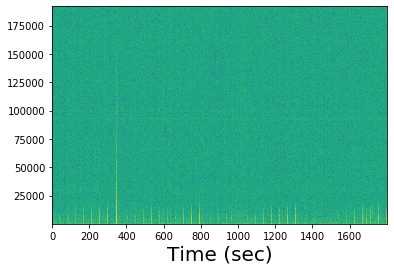

In [5]:
import matplotlib.pyplot as plt
print (P.shape, extent)
plt.imshow(P,extent=extent, aspect='auto')
plt.xlabel("Time (sec)", fontsize=20)
plt.show()


In [28]:
data = P_second_half #[:1920,:120000]
print (data.sum(0).mean())
data = data.sum(0)-data.sum(0).mean(0)

scale = P.shape[1]/200.
t=np.arange(P.shape[1])/200.

# find peaks
thresh = 18000
idx = np.where(data>thresh)[0]
idx_corrected=[]
idx_corrected.append(idx[0])
for k in range(1, idx.shape[0], 1):
    if idx[k]-idx[k-1]>5:
        idx_corrected.append(idx[k])
    
idx = np.array(idx_corrected)
#print (idx)

# find peaks that different various amounts
diffs = idx[1:]-idx[:-1]
print (diffs.shape)

idx2 = np.where(np.logical_and(diffs!=200,diffs>3,diffs!=199))[0]
print (diffs[idx2])

ax=plt.subplot(211)
plt.plot(t, data)
plt.plot([0,119999/200.],[thresh,thresh],c='red')
for id_ in idx_corrected:
    plt.plot([id_/200.,id_/200.],[0,30000],c='green')
for id_ in idx[idx2+1]:
    plt.plot([id_/200.,id_/200.],[0,30000],c='red')
    
ax=plt.subplot(212)
y = np.histogram(diffs, bins = np.arange(10,400,.001))
plt.plot(y[1][:-1]/scale,y[0])
ax.set_yscale('log')
plt.title("600 second audio recording of 1sec beeps", fontsize=20)
plt.xlabel("Inter-beep interval distributions (seconds)",fontsize=20)
plt.ylabel("# of frames apart by x-axis amount",fontsize=20)
plt.show()

-319652.6206017865
(1797,)
[201 197 201 201 201 201 201 201 199 201 197 201 197 201 197 201 201 201
 195 201 199 201 201 195 201 197 201 201 201 201 201 195 201 196 201 201
 197 201 201 196 201 201 201 201 196 201 201 201 197 197 201 201 201 197
 120  77 197 196 201 201 201 197 197 199 198 201 195 196 201 201 197  67
 130 195 201 201 195 201 201 196 201 201 201 201 201 201 197 201 201 201
 196 201 201 201 196 201 196 201 197 196 201 201 195]


In [27]:
idx_corrected_first_half = idx_corrected.copy()

#import wavio
#wavio.write("/media/cat/1TB/sync_test/audio/2020-4-20_09:16:47:293183.wav", data, 384000, sampwidth=1)

In [29]:
idx_corrected_second_half = idx_corrected.copy()


In [ ]:
_wav_file_ = "/media/cat/1TB/sync_test/audio/2020-4-20_09:16:47:293183.wav"

def spectogram_librosa(_wav_file_):
    import pylab
    import numpy as np

    (sig, rate) = librosa.load(_wav_file_, sr=None, mono=True,  dtype=np.float32)
    pylab.specgram(sig, Fs=rate)
    pylab.savefig('spectrogram3.png')

def graph_spectrogram_wave(wav_file):
    import wave
    import pylab
    def get_wav_info(wav_file):
        wav = wave.open(wav_file, 'r')
        frames = wav.readframes(-1)
        sound_info = pylab.fromstring(frames, 'int16')
        frame_rate = wav.getframerate()
        wav.close()
        return sound_info, frame_rate
    sound_info, frame_rate = get_wav_info(wav_file)
    pylab.figure(num=3, figsize=(10, 6))
    pylab.title('spectrogram pylab with wav_file')
    pylab.specgram(sound_info, Fs=frame_rate)
    pylab.savefig('spectrogram2.png')


def graph_wavfileread(_wav_file_):
    import matplotlib.pyplot as plt
    from scipy import signal
    from scipy.io import wavfile
    import numpy as np   
    sample_rate, samples = wavfile.read(_wav_file_)   
    frequencies, times, spectrogram = signal.spectrogram(samples,sample_rate,nfft=1024)
    plt.pcolormesh(times, frequencies, 10*np.log10(spectrogram))
    plt.ylabel('Frequency [Hz]')
    plt.xlabel('Time [sec]')
    plt.savefig("spectogram1.png")


spectogram_librosa(_wav_file_)
#graph_wavfileread(_wav_file_)
#graph_spectrogram_wave(_wav_file_)

In [2]:
amplitudes = np.load('/media/cat/1TB/amplitudes.npy')
print (amplitudes.shape)


ids = np.load('/media/cat/1TB/spike_clusters.npy')
print (ids.shape)

times = np.load('/media/cat/1TB/spike_times.npy')
print (times.shape)

spike_train = np.load('/media/cat/1TB/Dropbox/code/data/spike_train.npy')
print (spike_train.shape)

print (times[:25]-30)
print (spike_train[:25])

FileNotFoundError: [Errno 2] No such file or directory: '/media/cat/1TB/amplitudes.npy'

In [15]:
for k in range(10):
    idx = np.where(ids==k)[0]
    
    times1 = times[idx]-30
    
    for q in np.unique(spike_train[:,1]):
        idx2 = np.where(spike_train[:,1]==q)[0]
        times2 = spike_train[idx2,0]
        
        diffs = times1-times2
        idx3 = np.where(diffs==0)[0]
        if idx3.shape[0]>0:
            print ("Unit ",k, " matches unit: ", q, " # matches: ", idx3.shape)
    
    plt.scatter(times[idx] + k, amplitudes[idx])
plt.show()



Unit  0  matches unit:  4  # matches:  (1,)
Unit  0  matches unit:  28  # matches:  (1,)
Unit  0  matches unit:  47  # matches:  (1,)
Unit  0  matches unit:  85  # matches:  (1,)
Unit  1  matches unit:  0  # matches:  (1,)
Unit  1  matches unit:  89  # matches:  (1,)
Unit  1  matches unit:  96  # matches:  (1,)
Unit  1  matches unit:  116  # matches:  (1,)
Unit  1  matches unit:  122  # matches:  (1,)
Unit  1  matches unit:  127  # matches:  (1,)
Unit  1  matches unit:  182  # matches:  (1,)
Unit  2  matches unit:  49  # matches:  (1,)
Unit  2  matches unit:  135  # matches:  (1,)
Unit  4  matches unit:  118  # matches:  (1,)
Unit  5  matches unit:  17  # matches:  (1,)
Unit  5  matches unit:  25  # matches:  (1,)
Unit  5  matches unit:  122  # matches:  (1,)
Unit  5  matches unit:  153  # matches:  (1,)
Unit  6  matches unit:  88  # matches:  (1,)
Unit  6  matches unit:  104  # matches:  (1,)
Unit  7  matches unit:  118  # matches:  (1,)
Unit  8  matches unit:  83  # matches:  (1,)
Un

In [15]:
# visualize recomputed templates over time;
def binary_reader_waveforms(filename, n_channels, n_times, spikes, data_type='float32'):
    ''' Reader for loading raw binaries
    
        standardized_filename:  name of file contianing the raw binary
        n_channels:  number of channels in the raw binary recording 
        n_times:  length of waveform 
        spikes: 1D array containing spike times in sample rate of raw data
        channels: load specific channels only
        data_type: float32 for standardized data
    
    '''

    # ***** LOAD RAW RECORDING *****
    wfs=[]
    if data_type =='float32':
        data_len = 4
    else:
        data_len = 2
        
    with open(filename, "rb") as fin:
        for ctr,s in enumerate(spikes):
                #print (ctr,s)
            # index into binary file: time steps * 4  4byte floats * n_channels
            try:
                fin.seek(s * data_len * n_channels, os.SEEK_SET)
                wfs.append(np.fromfile(
                    fin,
                    dtype=data_type,
                    count=(n_times * n_channels)).reshape(n_times, n_channels))

            except:
                pass
    fin.close()
    return np.array(wfs)


fname = '/media/cat/1TB/data/synthetic/run3/data_int16.bin'
data_type = 'int16'
#fname = '/media/cat/1TB/synthetic/synthetic_600sec_385chan_drift_int16.bin'
#data_type = 'int16'

n_channels = 384
n_times = 101

if True:
    times = np.load('/media/cat/1TB/data/synthetic/run3/spike_times.npy')-n_times//2
    ids = np.load('/media/cat/1TB/data/synthetic/run3/spike_clusters.npy')
    spike_train = np.hstack((times,ids))
    
else:
    spike_train = np.load('/media/cat/1TB/data/synthetic/run3/ground_truth/spike_train_ground_truth.npy')

    
print (spike_train.shape)
print (spike_train)

units = np.unique(spike_train[:,1])
print ("units; ", units.shape)
templates = []
ptps = []
time_start = 0
time_end = time_start+600
wfs_array = []
times = []
for unit in units:#[:20]:
    if unit%10==0:
        print (unit)
    idx = np.where(spike_train[:,1]==unit)[0]
    #print (idx.shape)
    spikes = np.int32(spike_train[idx,0]) #-n_times//2#-30
    # sub sample spikes to speed up loading
    
    idx = np.where(np.logical_and(spikes>=(time_start*30000), spikes<(time_end*30000)))[0]
    spikes = spikes[idx]
    if idx.shape[0]==0:
        ptps.append([])
        templates.append(np.zeros((n_times,n_channels)))
        times.append([])
        continue

    times.append(spikes)
    #print (spikes.shape)
    
    # spikes = spikes[::10]
    wfs = binary_reader_waveforms(fname, n_channels, n_times, spikes, data_type)
    temp = wfs.mean(0)
    print (unit, wfs.shape, temp.shape)
    templates.append(temp)
    
    # max_chan
    max_chan = temp.ptp(0).argmax(0)
    wfs_array.append(wfs[:,:,max_chan])
    max_ = np.argmax(temp[:, max_chan])
    min_ = np.argmin(temp[:, max_chan])
    #max_= 57
    #min_ = 51
    
    ptp = wfs[:,max_,max_chan] - wfs[:,min_,max_chan]
    #ptp = wfs.ptp(1).max(1)
    print ("max chan:", max_chan, "PTP: ", ptp.mean(0))
    #print( "unit: ", unit, ", ptp: ", ptp)
    #print ("PTS: ", wfs.ptp(1).max(1))
    ptps.append(ptp)
    
    

(578505, 2)
[[      38      560]
 [      51       79]
 [      72      386]
 ...
 [17999770      445]
 [17999775      552]
 [17999784      331]]
units;  (611,)
0
0 (82, 101, 384) (101, 384)
max chan: 182 PTP:  57.71951219512195
1 (60, 101, 384) (101, 384)
max chan: 198 PTP:  67.91666666666667
2 (61, 101, 384) (101, 384)
max chan: 105 PTP:  68.95081967213115
3 (66, 101, 384) (101, 384)
max chan: 6 PTP:  58.77272727272727
4 (64, 101, 384) (101, 384)
max chan: 328 PTP:  69.0625
5 (116, 101, 384) (101, 384)
max chan: 34 PTP:  45.310344827586206
6 (104, 101, 384) (101, 384)
max chan: 236 PTP:  50.94230769230769
7 (69, 101, 384) (101, 384)
max chan: 7 PTP:  63.507246376811594
8 (61, 101, 384) (101, 384)
max chan: 7 PTP:  72.78688524590164
9 (61, 101, 384) (101, 384)
max chan: 7 PTP:  65.18032786885246
10
10 (71, 101, 384) (101, 384)
max chan: 50 PTP:  69.84507042253522
11 (8407, 101, 384) (101, 384)
max chan: 8 PTP:  239.98108718924706
12 (59, 101, 384) (101, 384)
max chan: 126 PTP:  70.69491

133 (59, 101, 384) (101, 384)
max chan: 299 PTP:  68.9322033898305
134 (119, 101, 384) (101, 384)
max chan: 337 PTP:  50.39495798319328
135 (60, 101, 384) (101, 384)
max chan: 22 PTP:  69.13333333333334
136 (62, 101, 384) (101, 384)
max chan: 358 PTP:  68.04838709677419
137 (60, 101, 384) (101, 384)
max chan: 166 PTP:  65.13333333333334
138 (61, 101, 384) (101, 384)
max chan: 257 PTP:  72.57377049180327
139 (7354, 101, 384) (101, 384)
max chan: 145 PTP:  225.8025564318738
140
140 (62, 101, 384) (101, 384)
max chan: 138 PTP:  82.80645161290323
141 (79, 101, 384) (101, 384)
max chan: 138 PTP:  52.63291139240506
142 (98, 101, 384) (101, 384)
max chan: 138 PTP:  55.51020408163265
143 (66, 101, 384) (101, 384)
max chan: 331 PTP:  60.07575757575758
144 (110, 101, 384) (101, 384)
max chan: 253 PTP:  45.236363636363635
145 (5016, 101, 384) (101, 384)
max chan: 145 PTP:  240.7408293460925
146 (71, 101, 384) (101, 384)
max chan: 145 PTP:  63.88732394366197
147 (104, 101, 384) (101, 384)
max chan

256 (6453, 101, 384) (101, 384)
max chan: 169 PTP:  265.3065240973191
257 (83, 101, 384) (101, 384)
max chan: 2 PTP:  59.265060240963855
258 (66, 101, 384) (101, 384)
max chan: 303 PTP:  61.56060606060606
259 (60, 101, 384) (101, 384)
max chan: 236 PTP:  63.6
260
260 (63, 101, 384) (101, 384)
max chan: 64 PTP:  71.63492063492063
261 (98, 101, 384) (101, 384)
max chan: 169 PTP:  60.265306122448976
262 (4346, 101, 384) (101, 384)
max chan: 170 PTP:  278.27220432581686
263 (70, 101, 384) (101, 384)
max chan: 269 PTP:  58.74285714285714
264 (82, 101, 384) (101, 384)
max chan: 277 PTP:  66.47560975609755
265 (117, 101, 384) (101, 384)
max chan: 277 PTP:  82.54700854700855
266 (74, 101, 384) (101, 384)
max chan: 170 PTP:  60.554054054054056
267 (61, 101, 384) (101, 384)
max chan: 348 PTP:  65.0
268 (65, 101, 384) (101, 384)
max chan: 286 PTP:  62.6
269 (71, 101, 384) (101, 384)
max chan: 171 PTP:  63.83098591549296
270
270 (73, 101, 384) (101, 384)
max chan: 141 PTP:  63.23287671232877
271 (

382 (9279, 101, 384) (101, 384)
max chan: 261 PTP:  215.45274275245177
383 (5244, 101, 384) (101, 384)
max chan: 261 PTP:  231.57246376811594
384 (60, 101, 384) (101, 384)
max chan: 191 PTP:  74.03333333333333
385 (63, 101, 384) (101, 384)
max chan: 37 PTP:  75.2063492063492
386 (7428, 101, 384) (101, 384)
max chan: 262 PTP:  292.96526655896605
387 (2312, 101, 384) (101, 384)
max chan: 261 PTP:  232.57093425605535
388 (64, 101, 384) (101, 384)
max chan: 313 PTP:  66.640625
389 (60, 101, 384) (101, 384)
max chan: 142 PTP:  72.35
390
390 (69, 101, 384) (101, 384)
max chan: 225 PTP:  60.492753623188406
391 (62, 101, 384) (101, 384)
max chan: 255 PTP:  77.25806451612904
392 (64, 101, 384) (101, 384)
max chan: 257 PTP:  65.171875
393 (71, 101, 384) (101, 384)
max chan: 143 PTP:  61.436619718309856
394 (64, 101, 384) (101, 384)
max chan: 280 PTP:  69.25
395 (77, 101, 384) (101, 384)
max chan: 265 PTP:  66.28571428571429
396 (67, 101, 384) (101, 384)
max chan: 24 PTP:  58.64179104477612
397 (

513 (12783, 101, 384) (101, 384)
max chan: 297 PTP:  341.50496753500744
514 (63, 101, 384) (101, 384)
max chan: 41 PTP:  63.333333333333336
515 (139, 101, 384) (101, 384)
max chan: 291 PTP:  41.8705035971223
516 (62, 101, 384) (101, 384)
max chan: 298 PTP:  84.16129032258064
517 (71, 101, 384) (101, 384)
max chan: 91 PTP:  65.87323943661971
518 (62, 101, 384) (101, 384)
max chan: 245 PTP:  67.66129032258064
519 (65, 101, 384) (101, 384)
max chan: 174 PTP:  66.13846153846154
520
520 (220, 101, 384) (101, 384)
max chan: 298 PTP:  49.04090909090909
521 (63, 101, 384) (101, 384)
max chan: 368 PTP:  71.42857142857143
522 (66, 101, 384) (101, 384)
max chan: 44 PTP:  58.03030303030303
523 (60, 101, 384) (101, 384)
max chan: 249 PTP:  71.25
524 (65, 101, 384) (101, 384)
max chan: 300 PTP:  78.03076923076924
525 (182, 101, 384) (101, 384)
max chan: 300 PTP:  42.04945054945055
526 (119, 101, 384) (101, 384)
max chan: 300 PTP:  39.67226890756302
527 (60, 101, 384) (101, 384)
max chan: 109 PTP:  7

In [23]:
# parse KS2 units and 
min_spikes = 600/2
max_spikes = 6000*10
good_units = []

for unit in range(len(ptps)):
    if (ptps[unit].shape[0]>min_spikes) and (ptps[unit].shape[0]<max_spikes):
        good_units.append(unit)
        
print ("# of good units: ", len(good_units), " of total KS2 units: ", len(ptps))




# of good units:  87  of total KS2 units:  611


In [ ]:
# match 

In [21]:
units=np.arange(5)
units = [good_units[3]]

for unit in units:
    fig = plt.figure()
    ax = plt.subplot(131)
    #plt.plot(templates[unit].T)
    plt.plot(wfs_array[unit].mean(0))

    ax = plt.subplot(132)
    #spikes = spikes[idx]
    spikes = times[unit]
    print ("spikes:", spikes.shape, "ptps: ", ptps[unit].shape)
    plt.scatter(spikes/30000., ptps[unit])

    ax=plt.subplot(133)
    max_chan = wfs_array[unit].mean(0).ptp(0).argmax(0)#templates[unit].ptp(0).argmax(0)
    print (wfs_array[unit].shape)

    cmap = cm.get_cmap('viridis',wfs_array[unit].shape[0])
    clrs = cmap(np.arange(wfs_array[unit].shape[0]))
    print (clrs)
    for k in range(0,wfs_array[unit].shape[0],10):
        plt.plot(wfs_array[unit][k].T,c=cmap(k))


plt.show()



spikes: (8210,) ptps:  (8210,)
(8210, 101)
[[0.267004 0.004874 0.329415 1.      ]
 [0.267004 0.004874 0.329415 1.      ]
 [0.267004 0.004874 0.329415 1.      ]
 ...
 [0.993248 0.906157 0.143936 1.      ]
 [0.993248 0.906157 0.143936 1.      ]
 [0.993248 0.906157 0.143936 1.      ]]


In [9]:
fname = '/home/cat/Downloads/yass/samples/10chan/phy/whitening_mat.npy'

n_channels = 10

whitening_mat = np.random.rand(n_channels,n_channels)

np.save(fname, whitening_mat)
print (whitening_mat.shape)
print (whitening_mat)

(10, 10)
[[0.61659694 0.20125714 0.48515898 0.45059603 0.89409843 0.8158124
  0.30200264 0.06808628 0.60955651 0.7760584 ]
 [0.19814057 0.21134196 0.27791917 0.52312241 0.20263871 0.21097603
  0.34816364 0.1852993  0.90506002 0.80562087]
 [0.970196   0.70466193 0.08746122 0.33371635 0.44791585 0.00678562
  0.41421277 0.65443008 0.8541354  0.41522301]
 [0.88052786 0.34072116 0.12298287 0.23288985 0.98943396 0.56546028
  0.38736253 0.87851743 0.83882004 0.96018176]
 [0.5622632  0.19456103 0.89831444 0.56587043 0.12599613 0.24817026
  0.47188959 0.55809954 0.72628178 0.72821972]
 [0.59236306 0.06332327 0.35662913 0.93425548 0.15622572 0.77164442
  0.62013196 0.67339586 0.97380542 0.9211003 ]
 [0.55011567 0.22242238 0.41892959 0.23396425 0.80036351 0.00612786
  0.72244072 0.1119026  0.84247935 0.13666388]
 [0.1674969  0.17014984 0.70297569 0.28534628 0.87704159 0.62894665
  0.38268201 0.47207143 0.53495952 0.46683818]
 [0.58624526 0.67612232 0.60880662 0.66169478 0.10866143 0.88197916
  0.

In [24]:
max_chans = templates.ptp(1).argmax(1)
ptps = templates.ptp(1).max(1)
ptps_all = templates.ptp(1)
print (ptps_all.shape)

print (max_chans)
print (ptps)


(426, 364)
[  0   1   1   1   2   3   4   6   7   5  10  13  14  14  15  16  17  18
  20  21  30  26  29  29  30  31  32  35  37  41  42  43  45  46  49  50
  38  56  58  60  69  68  68  68  72  70  71  74  75  76 342  80  79  80
  80  83  82  84 333  85  86  87  88  88  88  88  89  89  90  88  87  92
 336  94  95  98  99  84 101 103 104 108 109 109 111 111 111 112 114 115
 119 119 120 121 125 127 127 124 131 133 134 134 132 140 137 138 140 332
 140 140 141 142 142 140 143 145 146 147 147 149 149 149 149 150 284 149
 154 154 154 162 164 165 166 164 169 170 173 173 174 177 178 173 180 181
 182 186 182 185 185 186 186 189 190 192 194 197 198 199 201 204 204 206
 208 208 209 209 213 209 210 212 205 209 213 213 213 213 216 216 216 217
 219 220 226 228 229 229 229 230 230 233 235 215 236 236 238 239 239 242
 245 245 248 248 248 248 249 249 252 252 253 253 262 262 262 262 262 262
 262 262 262 262 262 262 252 265 265 265 266 266 257 268 268 253 273 273
 274 277 277 277 280 262 280 282 280 284

In [33]:
# plot scatter vs. depth
fig=plt.figure()
ax=plt.subplot(111)
for k in range(426):
    idx = np.where(spike_clusters==k)[0]
    times = spike_times[idx]/30000.
    plt.scatter(times, times*0+geom[max_chans[k],1]+(np.random.rand()*80-40),s=1, alpha=.9)
    
ax.tick_params(axis = 'both', which = 'major', labelsize = 20)
plt.ylim(3800,-100)
plt.xlim(-10,times[-1]+10)
plt.ylabel("Depth (um)",fontsize=20)
plt.xlabel("Time (sec)",fontsize=20)

plt.show()



In [74]:
diffs = np.random.rand(100)*100
scale = np.exp((diffs-100)/1000)
for k in range(diffs.shape[0]):
    print (k, diffs[k], scale[k])



0 50.04343866994906 0.9512707455391897
1 31.511094543965832 0.933803820173591
2 79.91591857042187 0.9801162602657848
3 72.12600610496935 0.9725109013917561
4 75.40719747880085 0.9757071366345005
5 48.62412826224273 0.9499215547562484
6 40.252282604094546 0.9420021543657597
7 19.901418010990668 0.9230253482265854
8 74.2364565504208 0.9745655047635049
9 10.109909418839402 0.9140316404370439
10 83.91309105885607 0.9840417943084782
11 15.851345568285424 0.9192945887226062
12 67.36962423365698 0.9678962513893601
13 20.096094187608628 0.9232050567642176
14 61.26441535509031 0.9620050444252287
15 9.342047612370797 0.9133300598433911
16 36.91786001399516 0.9388663520527735
17 66.03640423990359 0.9666066925789367
18 64.77231913402896 0.9653855914061126
19 87.76437095235895 0.9878389218924621
20 53.88185987067303 0.9549291400743297
21 4.3652565615853955 0.9087958991190807
22 47.354604541713755 0.9487163719757724
23 67.8751879930782 0.9683857083723731
24 52.986660794418306 0.9540746709073139
25 7